In [11]:
import os
import pathlib

import torchvision.datasets as dset
import torchvision.transforms as trn
from PIL import Image
from torch.utils.data import Dataset

def build_dataset(dataset_name, transform=None, mode="train"):
    #  path of usr
    usr_dir = os.path.expanduser('~')
    data_dir = os.path.join(usr_dir, "data")

    if dataset_name == 'imagenet':
        if transform == None:
            transform = trn.Compose([
                trn.Resize(256),
                trn.CenterCrop(224),
                trn.ToTensor(),
                trn.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
            ])

        dataset = dset.ImageFolder(data_dir + "/imagenet/val",
                                   transform)
    elif dataset_name == 'imagenetv2':
        if transform == None:
            transform = trn.Compose([
                trn.Resize(256),
                trn.CenterCrop(224),
                trn.ToTensor(),
                trn.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
            ])

        dataset = ImageNetV2Dataset(os.path.join(data_dir, "imagenetv2/imagenetv2-matched-frequency-format-val"),
                                    transform)

    elif dataset_name == 'mnist':
        if transform == None:
            transform = trn.Compose([
                trn.ToTensor(),
                trn.Normalize((0.1307,), (0.3081,))
            ])
        if mode == "train":
            dataset = dset.MNIST(data_dir, train=True, download=True, transform=transform)
        elif mode == "test":
            dataset = dset.MNIST(data_dir, train=False, download=True, transform=transform)

    else:
        raise NotImplementedError

    return dataset

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchcp.classification.loss import ConfTr
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.utils import fix_randomness

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Covariate shift')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--predictor', default="Standard", help="Standard")
    parser.add_argument('--score', default="THR", help="THR")
    parser.add_argument('--loss', default="CE", help="CE | ConfTr")
    args, unknown_args = parser.parse_known_args()
    res = {'Coverage_rate': 0, 'Average_size': 0}
    num_trials = 1
    for seed in range(num_trials):
        fix_randomness(seed=seed)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        ##################################
        # Invalid prediction sets
        ##################################
        train_dataset = build_dataset("mnist")
        train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True)


        class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()
                self.fc1 = nn.Linear(28 * 28, 500)
                self.fc2 = nn.Linear(500, 10)

            def forward(self, x):
                x = x.view(-1, 28 * 28)
                x = F.relu(self.fc1(x))
                x = self.fc2(x)
                return x


        model = Net().to(device)

        if args.loss == "CE":
            criterion = nn.CrossEntropyLoss()
        elif args.loss == "ConfTr":
            predictor = SplitPredictor(score_function=THR(score_type="log_softmax"))
            criterion = ConfTr(weights=0.01,
                               predictor=predictor,
                               alpha=0.05,
                               device=device,
                               fraction=0.5,
                               loss_types="valid",
                               base_loss_fn=nn.CrossEntropyLoss())
        else:
            raise NotImplementedError

        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


        def train(model, device, train_loader, optimizer, epoch):
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                if batch_idx % 10 == 0:
                    print(
                        f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


        checkpoint_path = f'cache/conformal_training_model_checkpoint_{args.loss}_seed={seed}.pth'
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
        # else:
        for epoch in range(1, 10):
            train(model, device, train_data_loader, optimizer, epoch)

        torch.save({'model_state_dict': model.state_dict(), }, checkpoint_path)

        test_dataset = build_dataset("mnist", mode='test')
        cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
        cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=1600, shuffle=False, pin_memory=True)
        test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1600, shuffle=False, pin_memory=True)

        if args.score == "THR":
            score_function = THR()
        elif args.score == "APS":
            score_function = APS()
        elif args.score == "RAPS":
            score_function = RAPS(args.penalty, args.kreg)
        elif args.score == "SAPS":
            score_function = SAPS(weight=args.weight)

        alpha = 0.01
        if args.predictor == "Standard":
            predictor = SplitPredictor(score_function, model)
        elif args.predictor == "ClassWise":
            predictor = ClassWisePredictor(score_function, model)
        elif args.predictor == "Cluster":
            predictor = ClusterPredictor(score_function, model, args.seed)
        predictor.calibrate(cal_data_loader, alpha)

        # test examples
        tmp_res = predictor.evaluate(test_data_loader)
        res['Coverage_rate'] += tmp_res['Coverage_rate'] / num_trials
        res['Average_size'] += tmp_res['Average_size'] / num_trials

    print(res)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.271197
Train Epoch: 1 [5120/60000 (8%)]	Loss: 1.883270
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.538871
Train Epoch: 1 [15360/60000 (25%)]	Loss: 1.254431
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.038548
Train Epoch: 1 [25600/60000 (42%)]	Loss: 0.891737
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.733198
Train Epoch: 1 [35840/60000 (59%)]	Loss: 0.727900
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.684935
Train Epoch: 1 [46080/60000 (76%)]	Loss: 0.621105
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.605014
Train Epoch: 1 [56320/60000 (93%)]	Loss: 0.579770
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.512335
Train Epoch: 2 [5120/60000 (8%)]	Loss: 0.502065
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.515545
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.507769
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.480250
Train Epoch: 2 [25600/60000 (42%)]	Loss: 0.421801
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.473772
Train Epoch: 2 [35840/60000 (59%)]	Loss: 0.425812
Train Epoch: 2

In [13]:
result = {}

score_functions = [
    (THR(), "Threshold"), 
#     (APS(), "Adaptive Prediction Set"), 
    (RAPS(penalty = 0.5, kreg = 1), "Regularized APS"), 
    (SAPS(weight = 0.5), "Sorted APS")
]

num_trials = 1
alpha = 0.05
for score_function, sname in score_functions:
    predictors = [
        (SplitPredictor(score_function, model), "Split"),
        (ClassWisePredictor(score_function, model), "ClassWise"),
        (ClusterPredictor(score_function, model, 0, num_clusters = 2), "Cluster")
    ]
    for predictor, pname in predictors:
        key = f"{sname} + {pname}"
        print(key)
        result[key] = {}
        predictor.calibrate(cal_data_loader, alpha)

        tmp_res = predictor.evaluate(test_data_loader)
        result[key]['Coverage_rate'] = tmp_res['Coverage_rate']
        result[key]['Average_size'] = tmp_res['Average_size']

print(result)

Threshold + Split
Threshold + ClassWise
Threshold + Cluster
Regularized APS + Split
Regularized APS + ClassWise
Regularized APS + Cluster
Sorted APS + Split
Sorted APS + ClassWise
Sorted APS + Cluster
{'Threshold + Split': {'Coverage_rate': 0.9484, 'Average_size': 1.0436}, 'Threshold + ClassWise': {'Coverage_rate': 0.947, 'Average_size': 1.0642}, 'Threshold + Cluster': {'Coverage_rate': 0.9484, 'Average_size': 1.0436}, 'Regularized APS + Split': {'Coverage_rate': 0.9468, 'Average_size': 1.0526}, 'Regularized APS + ClassWise': {'Coverage_rate': 0.95, 'Average_size': 1.1066}, 'Regularized APS + Cluster': {'Coverage_rate': 0.9484, 'Average_size': 1.0626}, 'Sorted APS + Split': {'Coverage_rate': 0.9506, 'Average_size': 1.1396}, 'Sorted APS + ClassWise': {'Coverage_rate': 0.95, 'Average_size': 1.1718}, 'Sorted APS + Cluster': {'Coverage_rate': 0.945, 'Average_size': 1.137}}


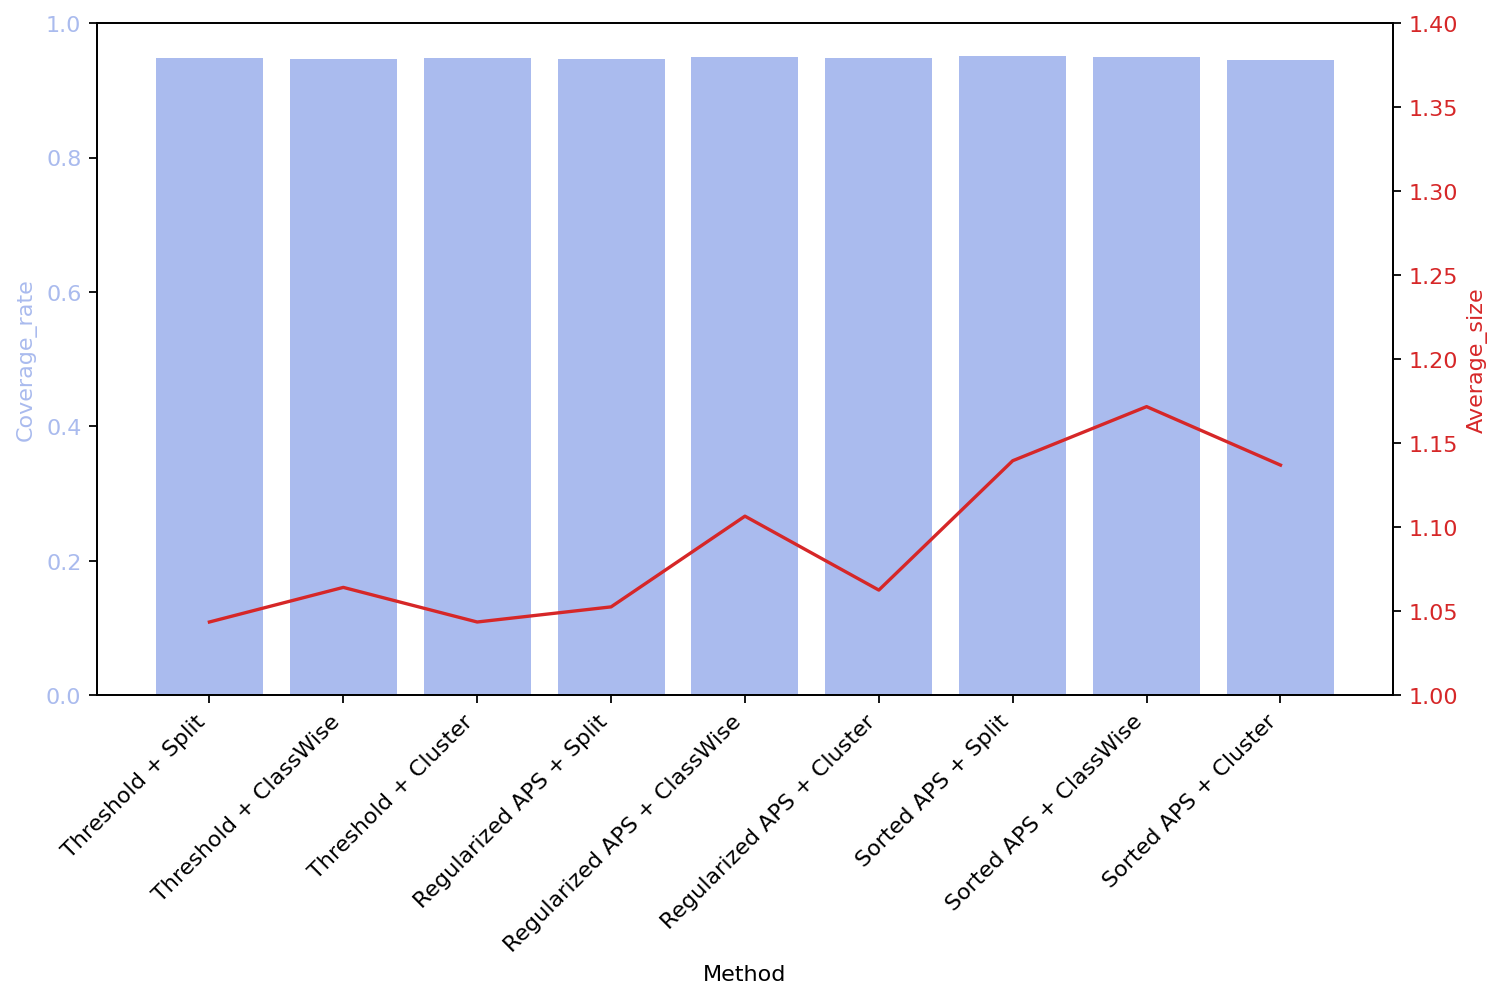

In [31]:
import matplotlib.pyplot as plt

labels = list(result.keys())
coverage_rates = [value['Coverage_rate'] for value in result.values()]
average_sizes = [value['Average_size'] for value in result.values()]

fig, ax1 = plt.subplots(figsize=(12, 6), dpi = 160)

color = '#AABBEE'
ax1.set_xlabel('Method')
ax1.set_ylabel('Coverage_rate', color=color)
ax1.bar(labels, coverage_rates, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average_size', color=color)
ax2.plot(labels, average_sizes, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(1, 1.4)

plt.subplots_adjust(bottom=0.2, right=0.8, top=0.9)

plt.xticks(rotation=45, ha='right')
fig.autofmt_xdate(rotation=45, ha='right')
plt.savefig('result.png', bbox_inches='tight')
plt.show()



<Figure size 640x480 with 0 Axes>